### Imports

In [1]:
import galsim
from matplotlib import pyplot as plt
plt.style.use(['dark_background'])
%matplotlib inline

import numpy as np
from SpecklePSF import SpeckleSeries
import pickle
import pandas as pd

scratchdir = '/global/cscratch1/sd/chebert/'
saveDir = './../Fits/hsmFits/'

# find all image files in the scratch directory
fileNames = ! ls /global/cscratch1/sd/chebert/rawSpeckles/ | grep 'img' 
fileNames = [f for f in fileNames if f not in ['img_a_004.fits', 'img_a_388.fits', 'img_a_389.fits',
                                               'img_b_004.fits', 'img_b_388.fits', 'img_b_389.fits']]

### Run minimal accumulation and fits on all speckles

In [2]:
# for file in fileNames:
#     fileNumber = file.split('.')[0].split('_')[-1]
#     test = SpeckleSeries(fileNumber, 'data', scratchdir)
#     test.fitExposures(fitMethod='hsm', 
#                       maxIters=10000, 
#                       max_amoment=5.0e6, 
#                       max_ashift=120, 
#                       savePath=saveDir)

#### load com and fwhm 

In [3]:
with open('./../Fits/centerOfMassB.p', 'rb') as file:
    comDictB = pickle.load(file)
with open('./../Fits/fwhmB.p', 'rb') as file:
    fwhmDictB = pickle.load(file)

with open('./../Fits/centerOfMassA.p', 'rb') as file:
    comDictA = pickle.load(file)
with open('./../Fits/fwhmA.p', 'rb') as file:
    fwhmDictA = pickle.load(file)

#### load all the fits and combine to an object each for g1, a g2, and a HLR

In [7]:
critA, critB, g1_a, g2_b, g1_b, g2_a = {}, {}, {}, {}, {}, {}
hlr_a, hlr_b, x_a, x_b, y_a, y_b = {}, {}, {}, {}, {}, {}

for file in fileNames:
    fileNumber = file.split('.')[0].split('_')[-1]
    with open(saveDir + 'hsm_img_a_' + fileNumber + '_cumulative.p', 'rb') as file:
        hsmA = pickle.load(file)
    with open(saveDir + 'hsm_img_b_' + fileNumber + '_cumulative.p', 'rb') as file:
        hsmB = pickle.load(file)

    critA[fileNumber] = comDictA['img_a_' + fileNumber + '.fits'] + \
                        fwhmDictA['img_a_' + fileNumber + '.fits']
    critB[fileNumber] = comDictB['img_b_' + fileNumber + '.fits'] + \
                        fwhmDictB['img_b_' + fileNumber + '.fits']
    
    g1_a[fileNumber] = hsmA['g1']
    g1_b[fileNumber] = hsmB['g1']
    
    g2_a[fileNumber] = hsmA['g2']
    g2_b[fileNumber] = hsmB['g2']
    
    hlr_a[fileNumber] = hsmA['hlr']
    hlr_b[fileNumber] = hsmB['hlr']
    
    x_a[fileNumber] = hsmA['x']
    x_b[fileNumber] = hsmB['x']
    
    y_a[fileNumber] = hsmA['y']
    y_b[fileNumber] = hsmB['y']

In [8]:
allFits = pd.DataFrame(data={'critA': critA, 'critB': critB, 
                             'g1_a': g1_a, 'g1_b': g1_b, 
                             'g2_a': g2_a, 'g2_b': g2_b, 
                             'hlr_a': hlr_a,'hlr_b': hlr_b,
                             'x_a': x_a, 'x_b': x_b,
                             'y_a': y_a, 'y_b': y_b,
                            })

### Ellipticity magnitude

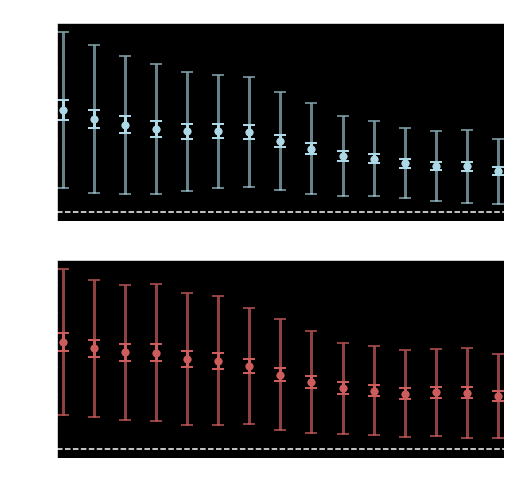

In [67]:
pts = np.logspace(-1.22,1.79,15)

N = len(allFits.index)
N_accepted = int(N)
accepted = np.zeros(N)

for i in range(N):
    fileNumber = allFits.index[i]
    accepted[i] = 0 if allFits['critA'].loc[fileNumber] >= 128 \
                or allFits['critB'].loc[fileNumber] >= 128 else 1  
    N_accepted += (accepted[i] - 1)

g = np.ones((2, N, 15))

for i in range(N):
    fileNumber = allFits.index[i]
    g[0, i] = np.sqrt(allFits['g1_a'].loc[fileNumber]**2 + allFits['g2_a'].loc[fileNumber]**2) * accepted[i]
    g[1, i] = np.sqrt(allFits['g1_b'].loc[fileNumber]**2 + allFits['g2_b'].loc[fileNumber]**2) * accepted[i]

gMean = g.sum(axis=1) / N_accepted
gStdDev = g.std(axis=1)
gMeanError = gStdDev / np.sqrt(N_accepted)
  
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.axhline(0, linestyle='--', color='w')
plt.errorbar(pts, gMean[0], yerr=gStdDev[0], fmt='o', color='lightblue', 
             capsize=6, linewidth=3, markeredgewidth=2, alpha=0.6)
plt.errorbar(pts, gMean[0], yerr=gMeanError[0], fmt='o', color='lightblue', 
             capsize=6, linewidth=3, markeredgewidth=2)
plt.title('filter a: 692 nm')
plt.ylabel('|g|')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([])

plt.subplot(2,1,2)
plt.axhline(0, linestyle='--', color='w')
plt.errorbar(pts, gMean[1], yerr=gStdDev[1], fmt='o', color='indianred', 
             capsize=6, linewidth=3, markeredgewidth=2, alpha=0.7)
plt.errorbar(pts, gMean[1], yerr=gMeanError[1], fmt='o', color='indianred', 
             capsize=6, linewidth=3, markeredgewidth=2)
plt.title('filter b: 880 nm')
plt.xlabel('exposure time')
plt.ylabel('|g|')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

### g1

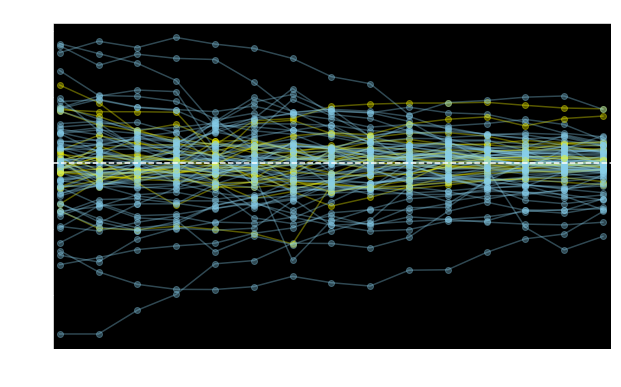

In [9]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'skyblue'    
    plt.plot(pts, allFits['g1_a'].loc[fileNumber], 'o-', alpha=0.35, color=c)

plt.axhline(0, linestyle='--', color='w')
plt.xlabel('exposure time')
plt.ylabel('g1')
plt.title('filter a: 692 nm')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

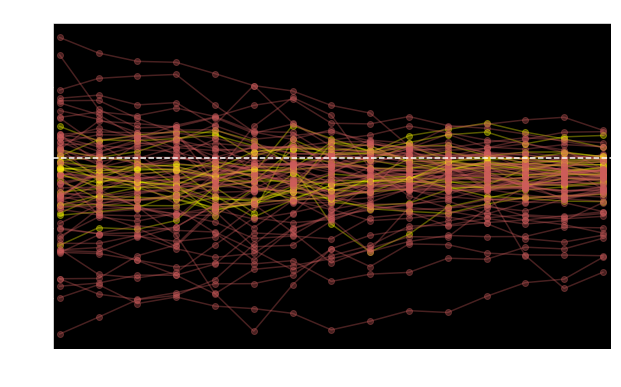

In [13]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 \
        or allFits['critB'].loc[fileNumber] >= 128 else 'indianred'    
    plt.plot(pts, allFits['g1_b'].loc[fileNumber], 'o-', alpha=0.35, color=c)

plt.axhline(0, linestyle='--', color='w')
plt.xlabel('exposure time')
plt.ylabel('g1')
plt.title('filter b: 692 nm')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

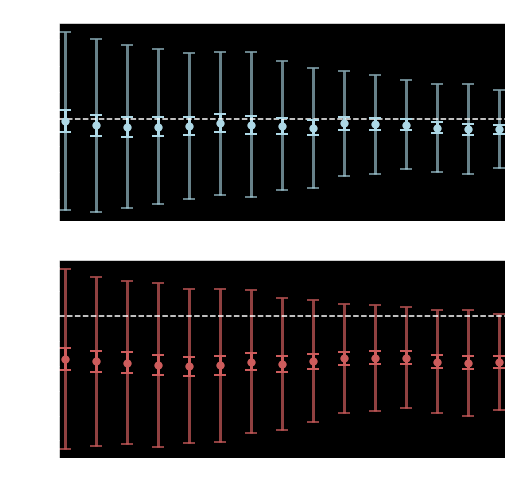

In [63]:
pts = np.logspace(-1.22,1.79,15)

N = len(allFits.index)
N_accepted = int(N)
accepted = np.zeros(N)

for i in range(N):
    fileNumber = allFits.index[i]
    accepted[i] = 0 if allFits['critA'].loc[fileNumber] >= 128 \
                or allFits['critB'].loc[fileNumber] >= 128 else 1  
    N_accepted += (accepted[i] - 1)

g1 = np.ones((2, N, 15))

for i in range(N):
    fileNumber = allFits.index[i]
    g1[0, i] = allFits['g1_a'].loc[fileNumber] * accepted[i]
    g1[1, i] = allFits['g1_b'].loc[fileNumber] * accepted[i]

g1Mean = g1.sum(axis=1) / N_accepted
g1StdDev = g1.std(axis=1)
g1MeanError = g1StdDev / np.sqrt(N_accepted)
  
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.axhline(0, linestyle='--', color='w')
plt.errorbar(pts, g1Mean[0], yerr=g1StdDev[0], fmt='o', color='lightblue', 
             capsize=6, linewidth=3, markeredgewidth=2, alpha=0.6)
plt.errorbar(pts, g1Mean[0], yerr=g1MeanError[0], fmt='o', color='lightblue', 
             capsize=6, linewidth=3, markeredgewidth=2)
plt.title('filter a: 692 nm')
plt.ylabel('g1')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([])

plt.subplot(2,1,2)
plt.axhline(0, linestyle='--', color='w')
plt.errorbar(pts, g1Mean[1], yerr=g1StdDev[1], fmt='o', color='indianred', 
             capsize=6, linewidth=3, markeredgewidth=2, alpha=0.7)
plt.errorbar(pts, g1Mean[1], yerr=g1MeanError[1], fmt='o', color='indianred', 
             capsize=6, linewidth=3, markeredgewidth=2)
plt.title('filter b: 880 nm')
plt.xlabel('exposure time')
plt.ylabel('g1')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

### g2

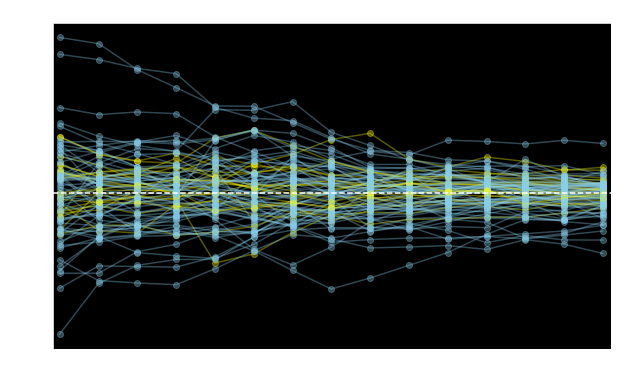

In [14]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 \
        or allFits['critB'].loc[fileNumber] >= 128 else 'skyblue'    
    plt.plot(pts, allFits['g2_a'].loc[fileNumber], 'o-', alpha=0.35, color=c)

plt.axhline(0, linestyle='--', color='w')
plt.xlabel('exposure time')
plt.ylabel('g2')
plt.title('filter a: 692 nm')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

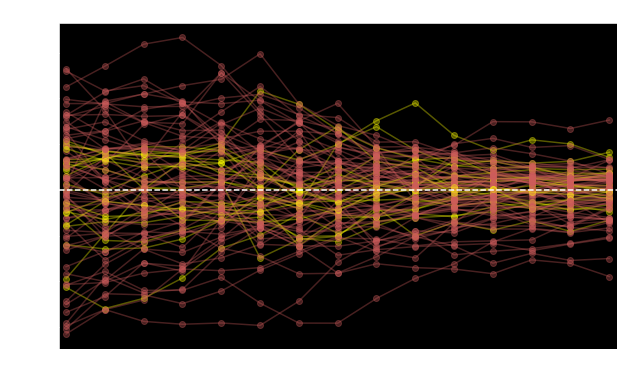

In [15]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'indianred'    
    plt.plot(pts, allFits['g2_b'].loc[fileNumber], 'o-', alpha=0.35, color=c)

plt.axhline(0, linestyle='--', color='w')
plt.xlabel('exposure time')
plt.ylabel('g2')
plt.title('filter b: 880 nm')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

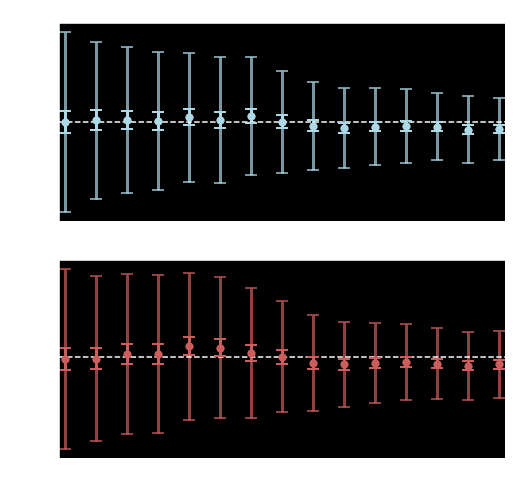

In [65]:
pts = np.logspace(-1.22,1.79,15)

N = len(allFits.index)
N_accepted = int(N)
accepted = np.zeros(N)

for i in range(N):
    fileNumber = allFits.index[i]
    accepted[i] = 0 if allFits['critA'].loc[fileNumber] >= 128 \
                or allFits['critB'].loc[fileNumber] >= 128 else 1  
    N_accepted += (accepted[i] - 1)

g2 = np.ones((2, N, 15))

for i in range(N):
    fileNumber = allFits.index[i]
    g2[0, i] = allFits['g2_a'].loc[fileNumber] * accepted[i]
    g2[1, i] = allFits['g2_b'].loc[fileNumber] * accepted[i]

g2Mean = g2.sum(axis=1) / N_accepted
g2StdDev = g2.std(axis=1)
g2MeanError = g2StdDev / np.sqrt(N_accepted)
  
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.axhline(0, linestyle='--', color='w')
plt.errorbar(pts, g2Mean[0], yerr=g2StdDev[0], fmt='o', color='lightblue', 
             capsize=6, linewidth=3, markeredgewidth=2, alpha=0.7)
plt.errorbar(pts, g2Mean[0], yerr=g2MeanError[0], fmt='o', color='lightblue', 
             capsize=6, linewidth=3, markeredgewidth=2)
plt.title('filter a: 692 nm')
plt.ylabel('g2')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([])

plt.subplot(2,1,2)
plt.axhline(0, linestyle='--', color='w')
plt.errorbar(pts, g2Mean[1], yerr=g2StdDev[1], fmt='o', color='indianred', 
             capsize=6, linewidth=3, markeredgewidth=2, alpha=0.7)
plt.errorbar(pts, g2Mean[1], yerr=g2MeanError[1], fmt='o', color='indianred', 
             capsize=6, linewidth=3, markeredgewidth=2)
plt.title('filter b: 880 nm')
plt.xlabel('exposure time')
plt.ylabel('g2')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

### g1 v g2

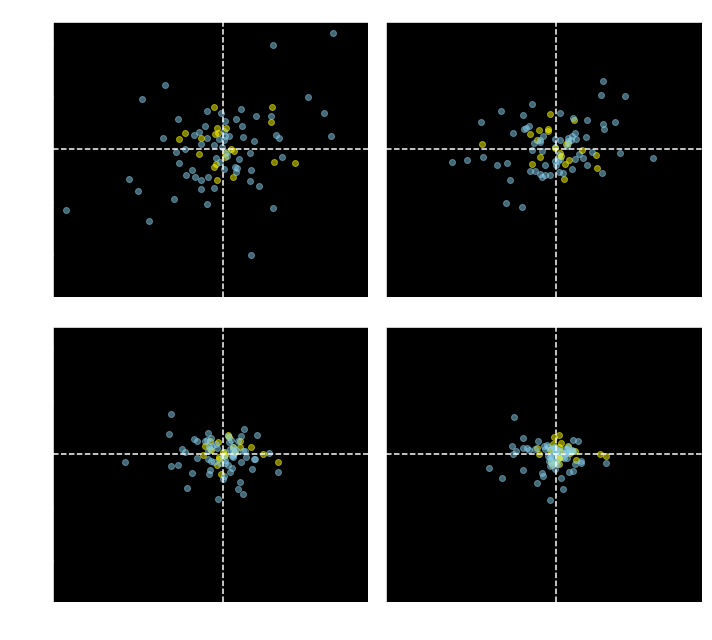

In [16]:
plt.figure(figsize=(10,9))
j = 0
times = [0, 1, 10, 60]
for i in [0, 6, 10, 14]:
    j += 1
    plt.subplot(2, 2, j)
    plt.title(str(times[j-1]) + ' sec')
    for fileNumber in allFits.index:
        c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'skyblue'
        plt.plot(allFits['g1_a'].loc[fileNumber][i], allFits['g2_a'].loc[fileNumber][i], 'o', alpha=0.5, color=c)

    if j in [1, 3]:
        plt.ylabel('g2')
    else:
        plt.yticks([])
    if j in [3, 4]:
        plt.xlabel('g1')
    else:
        plt.xticks([])
    plt.ylim([-.28,.24])
    plt.xlim([-.28,.24])
    plt.axhline(0, linestyle='--', color='w')
    plt.axvline(0, linestyle='--', color='w')
plt.tight_layout()
plt.show()

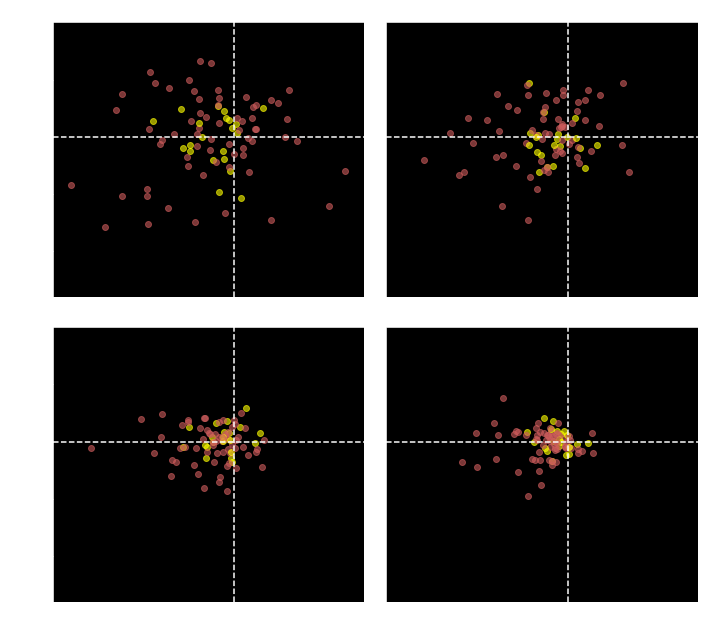

In [19]:
plt.figure(figsize=(10,9))
j = 0
for i in [0, 6, 10, 14]:
    j += 1
    plt.subplot(2, 2, j)
    plt.title(str(times[j-1]) + ' sec')
    for fileNumber in allFits.index:
        c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'indianred'
        plt.plot(allFits['g1_b'].loc[fileNumber][i], allFits['g2_b'].loc[fileNumber][i], 'o', alpha=0.6, color=c)

    if j in [1, 3]:
        plt.ylabel('g2')
    else:
        plt.yticks([])
    if j in [3, 4]:
        plt.xlabel('g1')
    else:
        plt.xticks([])
#     plt.xlim([-.3,.2])
#     plt.ylim([-.3,.2])
    plt.ylim([-.28,.2])
    plt.xlim([-.28,.2])
    plt.axhline(0, linestyle='--', color='w')
    plt.axvline(0, linestyle='--', color='w')
plt.tight_layout()
plt.show()

### HLR

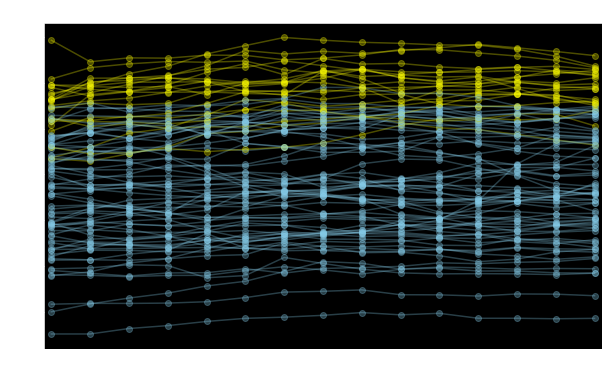

In [20]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'skyblue'    
    plt.plot(pts, allFits['hlr_a'].loc[fileNumber], 'o-', alpha=0.3, color=c)

plt.xlabel('exposure time')
plt.ylabel('HLR [arcsec]')
plt.title('filter a: 692 nm')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

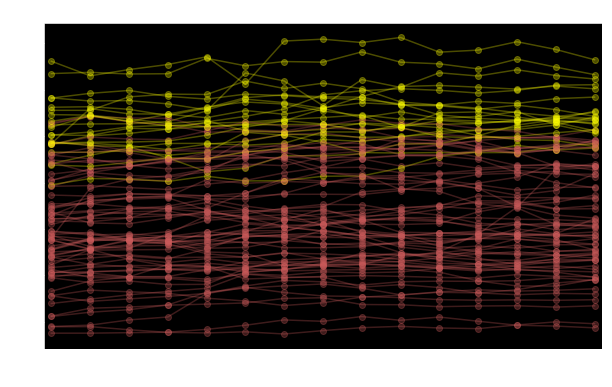

In [21]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'yellow' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'indianred'
    plt.plot(pts, allFits['hlr_b'].loc[fileNumber], 'o-', alpha=0.3, color=c)

# plt.axhline(0, linestyle='--', color='w')
plt.xlabel('exposure time')
plt.ylabel('HLR [arcsec]')
plt.title('filter b: 692 nm')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()

#### HLR ratio

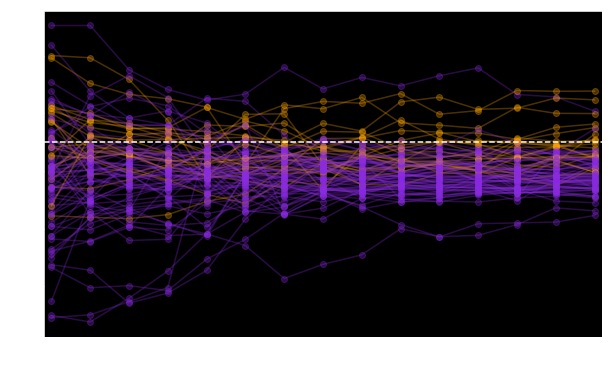

In [22]:
plt.figure(figsize=(10,6))
pts = np.logspace(-1.22,1.79,15)

for fileNumber in allFits.index:
    c = 'orange' if allFits['critA'].loc[fileNumber] >= 128 or allFits['critB'].loc[fileNumber] >= 128 else 'blueviolet'    
    plt.plot(pts, allFits['hlr_b'].loc[fileNumber] / allFits['hlr_a'].loc[fileNumber], 'o-', alpha=0.3, color=c)

plt.axhline(.95, linestyle='--', color='w')
plt.xlabel('exposure time')
plt.ylabel('HLR ratio b:a')
plt.xscale('log')
plt.xlim((0.055,.068*1000))
plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
plt.show()